# Fitting a Stage-Discharge Rating
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/thodson-usgs/ratingcurve/blob/master/notebooks/segmented-power-law-demo.ipynb)  

## Segmented power-law rating
There are several approaches to fitting a stage-discharge rating curve. 
The first section of this notebook demonstrates the classic approach, 
which is to use a segmented power law.

The segmented power law is defined as:

\begin{align}
    \log(Q) = a + \sum_{i=1}^{n} b_i \log(x - x_{o,i}) H_i(x - x_{o,i})
\end{align}
where
$Q$ is a vector discharge, \
$n$ is the number of breakpoints in the rating, \
$a$ and $b$ are model parameters, \
$x$ is a vector of stage observations, \
$x_o$ is a vector of breakpoints, and \
$H$ is the Heaviside function. 

In a standard linear model $b$ represents the slope of the function with respect the input.
In the segmented power law $b_o$ is the slope and each subsequent $b_i$ are adjustment to the base slope for each segment.

The later part of notebook demonstrates fitting a rating using a cubic spline.

In [ ]:
# # Only run this cell to setup Google Colab. It will take a minute.
# %%capture
# # Specific repo version used in this notebook
# !pip install pymc==4.1.1
#
# # Colab needs this
# %env MKL_THREADING_LAYER=GNU
#
# # install ratingcurve library
# !pip install git+https://github.com/thodson-usgs/ratingcurve.git

In [1]:
%load_ext autoreload
%autoreload 2

import pymc as pm
import arviz as az
from ratingcurve.ratingmodel import PowerLawRating, SplineRating

## Load Data

In [2]:
# load tutorial data
from ratingcurve import tutorial
tutorial.list_datasets()

['simulated_rating',
 'chalk_artificial',
 'provo_natural',
 'co_channel',
 'green_channel']

and load a specific dataset.

In [3]:
df = tutorial.open_dataset('green_channel')
df.head()

,datetime,stage,q,q_sigma
0,2020-05-21 14:13:41 [UTC-07:00],7.04,12199.342,199.172931
1,2020-04-16 14:55:31 [UTC-07:00],4.43,4921.953,95.425619
2,2020-03-04 13:54:10 [UTC-07:00],2.99,2331.665,61.860500
3,2020-03-04 13:16:51 [UTC-07:00],2.94,2289.220,47.886745
4,2020-01-23 11:04:32 [UTC-07:00],2.96,2408.210,99.522964


Text(0, 0.5, 'Stage (ft)')

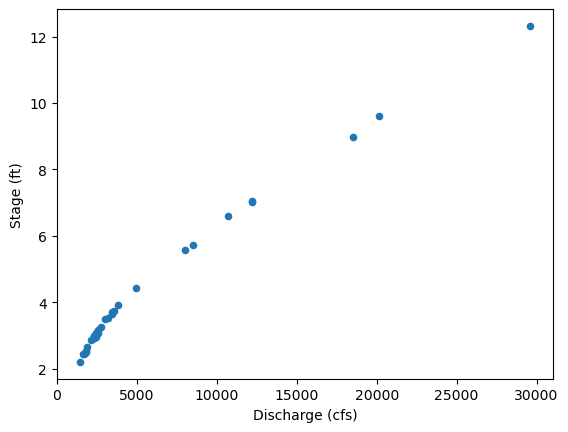

In [4]:
# plot the data
ax = df.plot.scatter(x='q', y='stage', marker='o')
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Stage (ft)")

## Setup model
Setup a rating model. This make take a minute while the model compiles.

In [5]:
segments = 2
powerrating = PowerLawRating(q=df['q'],
                             h=df['stage'], 
                             q_sigma=df['q_sigma'],
                             segments=segments,
                             prior={'distribution':'uniform'})

then fit the model using variational inference (this will be slower on the first run). Set the number of iterations `n` such that the model stops after the loss stops decreasing.

In [6]:
with powerrating:
    mean_field = pm.fit(method='advi', n=150_000)
    trace = mean_field.sample(5000)

Finished [100%]: Average Loss = -44.578


Once fit, we can evaluate the model by plotting the rating curve.

/home/thodson/.mambaforge/envs/ratingcurve/lib/python3.10/site-packages/matplotlib/patches.py:1145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/mnt/c/Users/thodson/Desktop/Projects/uncertainty/ratingcurve/src/ratingcurve/ratingmodel.py:216: RuntimeWarning: invalid value encountered in log
  b1 = np.where(h_tile<=hs, clips, np.log(h_tile-h0))


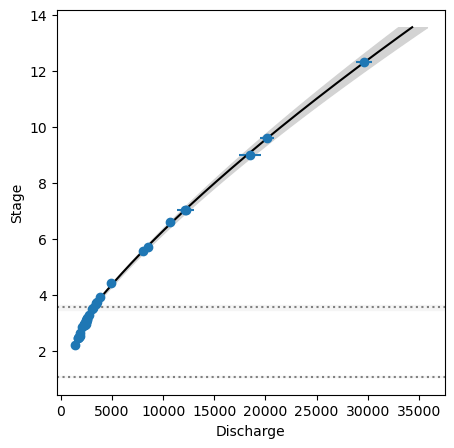

In [7]:
powerrating.plot(trace)

or as a table of stage-discharge values.

In [8]:
table = powerrating.table(trace)
table.head()

,discharge,stage,sigma
0,1378.56,2.21,1.0116
1,1391.15,2.22,1.0116
2,1403.75,2.23,1.0115
3,1416.35,2.24,1.0114
4,1428.95,2.25,1.0113


## Exercise
What happens if we choose the wrong number of segments? 
Increase the number of segments by one and rerun the model.

## Simulated Example
This example uses a simulated rating curve, which allows you to test how different sampling schemes affect the rating curve fit.

First, open the `simulated_rating` tutorial dataset.

In [9]:
sim_df = tutorial.open_dataset('simulated_rating')
print('The simulated rating contains {} observations'.format(len(sim_df)))

The simulated rating contains 763 observations


This rating contains observations of every 0.01 inch. increment in stage, which is much more than we'd have for a natural rating.
Try sampling to `n=15` or `n=30` and see how that affects the model fit.

Text(0, 0.5, 'Stage (ft)')

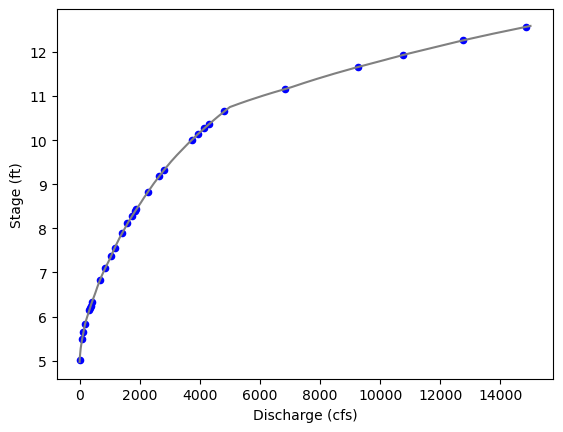

In [10]:
# subsample the simulated rating curve
n = 30
df = sim_df.sample(n, random_state=12345)

ax = sim_df.plot(x='q', y='stage', color='grey', ls='-', legend=False)
df.plot.scatter(x='q', y='stage', marker='o', color='blue', ax=ax)
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Stage (ft)")

Setup a rating model with 3 segments

In [11]:
segments = 3
powerrating = PowerLawRating(q=df['q'],
                             h=df['stage'],
                             q_sigma=None,
                             segments=segments,
                             prior={'distribution':'uniform'})

now fit the model using ADVI

In [12]:
with powerrating:
    method = 'advi'
    mean_field = pm.fit(method=method, n=100_000) #increase n as necessary
    trace = mean_field.sample(5000)

Finished [100%]: Average Loss = -50.368


and visualize the results.

/home/thodson/.mambaforge/envs/ratingcurve/lib/python3.10/site-packages/matplotlib/patches.py:1145: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  xy = np.asarray(xy)
/mnt/c/Users/thodson/Desktop/Projects/uncertainty/ratingcurve/src/ratingcurve/ratingmodel.py:216: RuntimeWarning: invalid value encountered in log
  b1 = np.where(h_tile<=hs, clips, np.log(h_tile-h0))


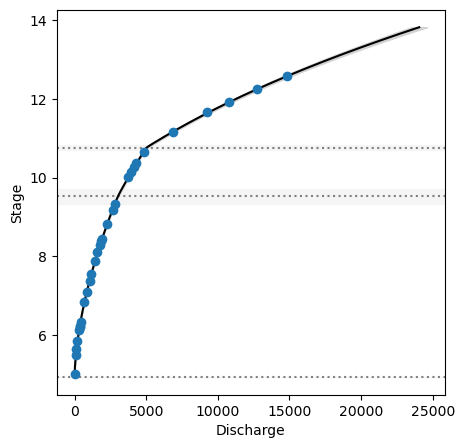

In [13]:
powerrating.plot(trace, None)

In [15]:
az.summary(trace, var_names=["w", "a", "sigma", "hs"])

arviz - WARNING - Shape validation failed: input_shape: (1, 5000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.969,0.001,0.966,0.971,0.000,0.000,5017.0,4857.0,NaN
w[1],0.308,0.006,0.296,0.319,0.000,0.000,4978.0,4744.0,NaN
w[2],0.075,0.004,0.068,0.081,0.000,0.000,4934.0,4869.0,NaN
a,-0.998,0.002,-1.001,-0.994,0.000,0.000,4948.0,5055.0,NaN
sigma,0.010,0.001,0.007,0.013,0.000,0.000,4869.0,4751.0,NaN
"hs[0, 0]",4.932,0.001,4.930,4.933,0.000,0.000,4920.0,4814.0,NaN
"hs[1, 0]",10.759,0.030,10.700,10.814,0.000,0.000,5207.0,4673.0,NaN
"hs[2, 0]",9.521,0.100,9.340,9.713,0.001,0.001,5053.0,5025.0,NaN


ADVI typically underestimates uncertainty; NUTS may give better results but will be substantially slower to fit.

In [16]:
# NUTS example. This may take several minutes, depending on your CPU.
# n = 4
# with powerrating:
#     trace = pm.sample(tune=1500, chains=n, cores=n, target_accept=0.95)

# powerrating.plot(trace)

## Spline demo
Splines are another approach used to fit a stage-discharge ratings. Splines have the advantage of being very easy (fast) to fit, but their form is less constrained than the segmented power law. As a result, splines may produce strange results, particularly with small datasets.

In [34]:
import numpy as np

df = tutorial.open_dataset('green_channel')

spline_rating = SplineRating(q=df['q'],
                             h=df['stage'],
                             q_sigma=df['q_sigma'],
                             df=8)

Finished [100%]: Average Loss = -36.421


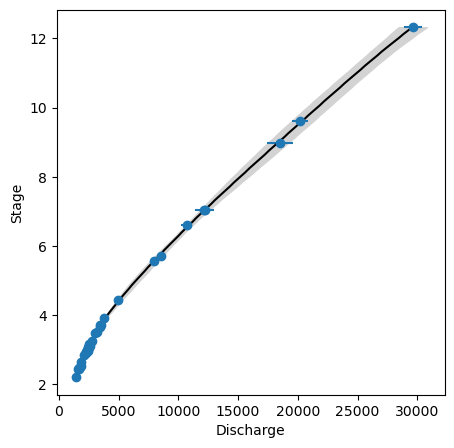

In [35]:
# requires fewer iterations than power law
with spline_rating:
    mean_field = pm.fit(method='advi', n=70_000)
    trace = mean_field.sample(5000)

spline_rating.plot(trace)

In this case, the spline is similar to the power law, but set `n_knots=5`.

### Spline with simulated data

In [47]:
sim_df = tutorial.open_dataset('simulated_rating')

Text(0, 0.5, 'Stage (ft)')

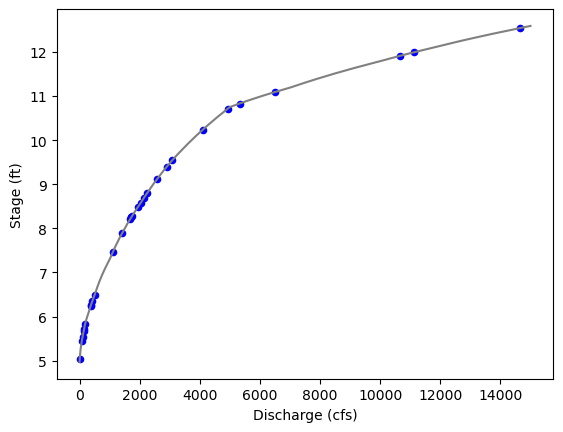

In [61]:
# subsample the simulated rating curve
n = 30
df = sim_df.sample(n)

ax = sim_df.plot(x='q', y='stage', color='gray', ls='-', legend=False)
df.plot.scatter(x='q', y='stage', marker='o', color='blue', ax=ax)
ax.set_xlabel("Discharge (cfs)")
ax.set_ylabel("Stage (ft)")

In [62]:
spline_rating = SplineRating(q=df['q'],
                             h=df['stage'],
                             df=10)

Finished [100%]: Average Loss = -4.0376


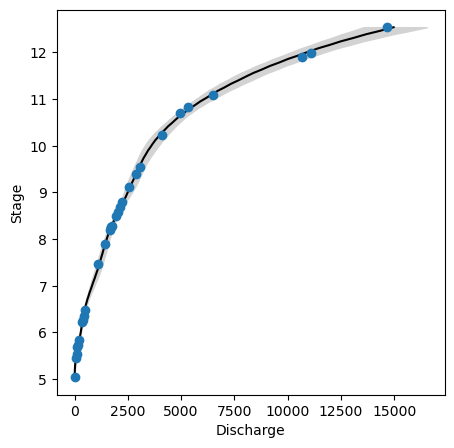

In [63]:
with spline_rating:
    mean_field = pm.fit(method='advi', n=100_000)
    trace = mean_field.sample(5000)

spline_rating.plot(trace)

### Excercise 
Splines can give unexpectedly poor results.
For example, try 
`sim_df.sample(n=30, random_state=771)`  